### Support Vector Machine  (with Gaussian Kernel) 

Sequential Minimization Optimization algorithm code was made available through: 
http://jonchar.net/notebooks/SVM/

for annotated version of SMO Algorithm code, see Support Vector Machine (Linear Kernel) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

class SMOModel:
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X                
        self.y = y                
        self.C = C                
        self.kernel = kernel      
        self.alphas = alphas      
        self.b = b               
        self.errors = errors      
        self.obj_results = []     
        self.m = len(self.X)      
        
def linear_kernel(xi, xj, b=1):
    return np.dot(xi, xj.T) + b

def train(model):
    kOne, kTwo = 0, 1    
    while kOne > 0 or kTwo > 0:
        kOne = 0    
        if kTwo > 0:
            for i in range(model.alphas.shape[0]):
                examined_flag, model = examine(i, model)
                kOne += examined_flag                
                if examined_flag:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model.obj_results.append(obj_result)
        else:  
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examined_flag, model = examine(i, model)
                kOne += examined_flag
                if examined_flag:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model.obj_results.append(obj_result)
        if kTwo == 1:
            kTwo = 0
        elif kOne == 0:
            kTwo = 1
    return model

def examine(i2, model):
    alph2 = model.alphas[i2]  
    y2 = model.y[i2]
    E2 = model.errors[i2]
    if ( ( (E2*y2) < -tol and alph2 < model.C) or ( (E2*y2) > tol and alph2 > 0) ):
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)               
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))): 
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    return 0, model

def take_step(i1, i2, model):
    if i1 == i2:
        return 0, model
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    if (y1 != y2):                             
        L = max(0, alph2 - alph1)                  
        H = min(model.C, model.C + alph2 - alph1)  
    elif (y1 == y2):                           
        L = max(0, alph1 + alph2 - model.C)       
        H = min(model.C, alph1 + alph2)            
    if (L == H):
        return 0, model
    k12 = model.kernel(model.X[i1], model.X[i2])
    k11 = model.kernel(model.X[i1], model.X[i1])
    k22 = model.kernel(model.X[i2], model.X[i2])
    step = 2 * k12 - k11 - k22                
    if (step < 0):                                
        a2 = alph2 - y2 * (E1 - E2) / step        
        if L < a2 < H: 
            a2 = a2          
        elif (a2 <= L):      
            a2 = L           
        elif (a2 >= H):
            a2 = H
    else:  
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        obj_result_at_L = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        obj_result_at_H = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if obj_result_at_L > obj_result_at_H + eps:    
            a2 = L                    
        elif obj_result_at_L < (obj_result_at_H - eps):   
            a2 = H
        else:
            a2 = alph2
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    a1 = alph1 + s * (alph2 - a2)   
    b1  =  E1  +  y1*(a1 - alph1) *  k11    +  y2*(a2 - alph2) *  k12   +  model.b
    b2  =  E2  +  y1*(a1 - alph1) *  k12    +  y2*(a2 - alph2) *  k22   +  model.b
    if 0 < a1 and a1 < C:  
        b_new = b1
    elif  0 < a2 and a2 < C:
        b_new = b2
    else:  
        b_new = (b1+b2) * 0.5
    model.alphas[i1], model.alphas[i2] = a1, a2
    for ix, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[ix] = 0.0
    oth_pts = [k for k in range(model.m) if (k != i1 and k != i2)]
    model.errors[oth_pts] = model.errors[oth_pts] + \
                            y1*(a1 - alph1) * model.kernel(model.X[i1], model.X[oth_pts])+\
                            y2*(a2 - alph2) * model.kernel(model.X[i2], model.X[oth_pts])+\
                            model.b - b_new
    model.b = b_new
    return 1, model

def objective_function(alphas, target, kernel, X):
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X, X) * alphas * alphas)

def decision_function(alphas, target, kernel, xi, xj, b):
    result = np.dot( (alphas * target), kernel(xi, xj) ) - b
    return result

Gaussian kernel

In [2]:
def gaussian_kernel(xi, xj, sigma=1.0):
    '''
    Returns 
    
      <zi,zj> - inner product of xi,xj transformations to high dimensional space
      
                  scenario-a: if inputs are both vectors, a scalar is returned                
                  scenario-b: if inputs are matrix and vector, a vector is returned    
                  scenario-c: if inputs are both matrices, a matrix is returned
        '''
    #scenario-a
    if np.ndim(xi) == 1 and np.ndim(xj) == 1:           
        distances = np.linalg.norm(xi - xj)

    #scenario-b   
    elif (np.ndim(xi)==2 and np.ndim(xj)==1) or (np.ndim(xi)==1 and np.ndim(xj)==2): 
        distances = np.linalg.norm(xi - xj, axis=1)

    #scenario-c   
    elif np.ndim(xi)==2 and np.ndim(xj)==2: 
        distances = np.exp(- np.linalg.norm(xi[:,np.newaxis] - xj[np.newaxis,:], axis=2))
        
    gamma = 1.0 / (2.0 * sigma**2)

    return np.exp(- gamma * distances**2)

Data - not linearly separable

In [3]:
def scale_dataset(A):
    A_T, new_A, j =  np.array(A).T, [], 0
    means = [np.mean(row) for row in A_T]
    stds  = [np.std(row) for row in A_T]
    for row in A_T:
        new_A.append( [(i - means[j]) / stds[j] for i in row] )
        j += 1
    return np.array(new_A).T

# set random.seed
np.random.seed(3)
                
# create points to be used for class-0
npoints, X1, X2 = 50, [], []
X1.append(np.random.uniform(low=0.0, high=2.4, size=npoints))   
X2.append(np.random.uniform(low=0.0, high=2.4, size=npoints))

# create points to be used for class-1
X1.append(np.random.uniform(low=1.2, high=3.6, size=npoints))
X2.append(np.random.uniform(low=1.2, high=3.6, size=npoints))

# create dataset and labels  
X, y = [], []
for i in range(2):
    points = zip( X1[i], X2[i] )
    for p in points:
        X.append( [p[0], p[1]] )
    for n in range(npoints):
        y.append(i)
X, y = scale_dataset(X), np.array(y) 
y[y==0] = -1

# train, test splits
indices = range(len(X))
XTest   = np.array([X[i] for i in indices if i%3 == 0])
XTrain  = np.array([X[i] for i in indices if i%3 != 0])
yTest   = np.array([y[i] for i in indices if i%3 == 0])
yTrain  = np.array([y[i] for i in indices if i%3 != 0])

Run model

In [4]:
kernel = gaussian_kernel
C   = 1000 
eps = 0.01 
tol = 0.01
m = len(XTrain)
model = SMOModel(XTrain, yTrain, C, kernel, np.zeros(m), 0.0, np.zeros(m))
initial_error = decision_function(model.alphas, yTrain, kernel, XTrain, 
                                  XTrain, model.b) - yTrain
model.errors = initial_error
np.random.seed(0)
output = train(model)
alphas, b = output.alphas, output.b

Plot

       data point           class  alpha (lagrange multiplier)

[-0.15541227 -0.53333197]   -1      609.195463137

[-0.96522925  0.41214136]   -1      0.548858651329

[-0.37981998 -0.32981084]   -1      399.435758223

[ 1.92818852 -0.27898705]   1      0.720365553481

[-0.37060206  1.79168328]   1      2.66453937678

[-0.23110356 -0.43496408]   1      1000.0

[ 1.577404    1.73320855]   1      3.56020979649

[ 1.58771418 -0.48077288]   1      2.23496528455


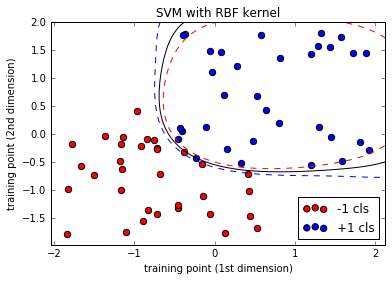

In [5]:
ix, nv, nh, pv, ph = 0, [], [], [], []
for ix in range(m):
    if yTrain[ix] == -1:
        nv.append(XTrain[:,0][ix])
        nh.append(XTrain[:,1][ix])
    else:
        pv.append(XTrain[:,0][ix])
        ph.append(XTrain[:,1][ix])
    ix += 1
minv, maxv  = np.min(XTrain[:,0])-0.20, np.max(XTrain[:,0])+.20
minh, maxh  = np.min(XTrain[:,1])-0.20, np.max(XTrain[:,1])+.20
axes = plt.gca()
axes.set_xlim([minv, maxv]) 
axes.set_ylim([minh, maxh]) 
plt.scatter(nv, nh, c='r', marker = 'o', s=40, label='-1 cls')
plt.scatter(pv, ph, c='b', marker = 'o', s=40, label='+1 cls')
plt.title('SVM with RBF kernel')
plt.xlabel('training point (1st dimension)')
plt.ylabel('training point (2nd dimension)')
linsp_v = np.linspace( minv, maxv, 100 )
linsp_h = np.linspace( minh, maxh, 100 )
boundary = [[decision_function(alphas, yTrain, kernel, XTrain, np.array([xr, yr]), 
                               b) for yr in linsp_h] for xr in linsp_v]
boundary = np.array(boundary).reshape(len(linsp_v), len(linsp_h))
axes.contour(linsp_v, linsp_h, boundary, (-1, 0, 1), linewidths=(1, 1, 1), 
           linestyles=('--', '-', '--'), colors=('b','k','r'))
plt.legend(loc='lower right')
print '       data point           class  alpha (lagrange multiplier)'
for i in range(m):
    if alphas[i] > 0:
        print '\n', XTrain[i], ' ', yTrain[i], '    ', alphas[i]

Weights

In [6]:
def w_vector(X, y, alphas):
    '''
    Returns vector of weights. ( y * alpha is scalar, which, dotted with a
    training vector, results in a vector; sum of vectors results in a vector ) 
    '''
    return sum(np.dot((y[i] * alphas[i]), X[i]) for i in range(len(alphas)))

w_vector(XTrain, yTrain, alphas)

array([ 25.38224254,  31.12048682])

Accuracy scoring

In [7]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    accuracy_result = correct / float(len(actual)) * 100.
    return accuracy_result

prediction_values = []
for pt in XTest:
    result = decision_function(alphas, yTrain, kernel, XTrain, np.array(pt), b)
    prediction_values.append( np.sign(result) )
    
accuracy_metric(yTest, prediction_values)

88.23529411764706

Predictions on given points

In [8]:
# specify points with which prediction is being made on
pts = [ [1.5, -1.5], [1.5, -1.0], [0, 0], [-1.0, 1.0] ]

print 'predictions using decision function'
for pt in pts:
    result = decision_function(alphas, yTrain, kernel, XTrain, np.array(pt), b)
    print 'point:', pt, '  decision value:', round(result, 3),
    if np.sign(result) < 0: 
        print 'class: -1'
    else: 
        print 'class: +1'

predictions using decision function
point: [1.5, -1.5]   decision value: -6.156 class: -1
point: [1.5, -1.0]   decision value: -3.414 class: -1
point: [0, 0]   decision value: 9.649 class: +1
point: [-1.0, 1.0]   decision value: -3.862 class: -1
